# Imports

In [1]:
import collections
import math
import os
import random
import torch
import matplotlib.pyplot as plt
from torch import nn
import time
import numpy as np
import re

# Dataset

In [2]:
def read_ptb():
    """Load the PTB dataset into a list of text lines."""
    data_dir = 'ptb/'
    # Read the training set
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()
f'# sentences: {len(sentences)}'

'# sentences: 42069'

In [3]:
def preprocess(text):
    return re.sub('[^A-Za-z]+', ' ', text).lower()
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        """Defined in :numref:`sec_text-sequence`"""
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']
    
def tokenize(text):
    return list(text)

def build(raw_text, vocab=None):
    tokens = tokenize(preprocess(raw_text))
    if vocab is None: vocab = Vocab(tokens)
    corpus = [vocab[token] for token in tokens]
    return corpus, vocab


In [4]:
vocab = Vocab(sentences, min_freq=10)
f'vocab size: {len(vocab)}'

'vocab size: 6719'

## Subsampling

In [5]:
def subsample(sentences, vocab):
    """Subsample high-frequency words."""
    # Exclude unknown tokens ('<unk>')
    sentences = [[token for token in line if vocab[token] != vocab.unk]
                 for line in sentences]
    counter = collections.Counter([
        token for line in sentences for token in line])
    num_tokens = sum(counter.values())

    # Return True if `token` is kept during subsampling
    def keep(token):
        return(random.uniform(0, 1) <
               math.sqrt(1e-4 / counter[token] * num_tokens))

    return ([[token for token in line if keep(token)] for line in sentences],
            counter)

subsampled, counter = subsample(sentences, vocab)

In [6]:
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """Plot the histogram for list length pairs.

    Defined in :numref:`sec_machine_translation`"""
    plt.figure(figsize=(6, 4))
    _, _, patches = plt.hist(
        [[len(l) for l in xlist], [len(l) for l in ylist]])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    plt.legend(legend)
    plt.show()

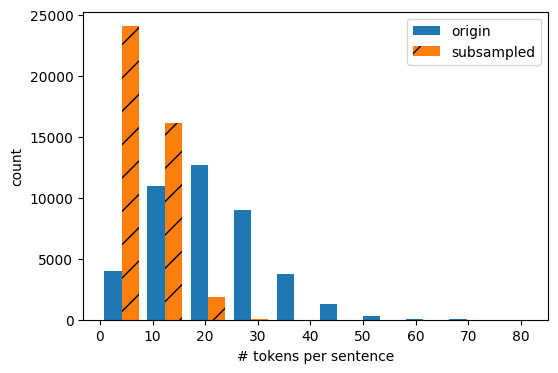

In [7]:
show_list_len_pair_hist(['origin', 'subsampled'], '# tokens per sentence',
                            'count', sentences, subsampled);

In [8]:
def compare_counts(token):
    return (f'# of "{token}": '
            f'before={sum([l.count(token) for l in sentences])}, '
            f'after={sum([l.count(token) for l in subsampled])}')

compare_counts('the')

'# of "the": before=50770, after=1984'

In [9]:
compare_counts('join')

'# of "join": before=45, after=45'

In [10]:
corpus = [vocab[line] for line in subsampled]
corpus[:3]

[[], [3228, 4060], [3922, 1922, 4743, 2696]]

## Center and Context Words

In [11]:
def get_centers_and_contexts(corpus, max_window_size):
    """Return center words and context words in skip-gram."""
    centers, contexts = [], []
    for line in corpus:
        # To form a "center word--context word" pair, each sentence needs to
        # have at least 2 words
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # Context window centered at `i`
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # Exclude the center word from the context words
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

In [12]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('dataset', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('center', center, 'has contexts', context)

dataset [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center 0 has contexts [1]
center 1 has contexts [0, 2]
center 2 has contexts [1, 3]
center 3 has contexts [2, 4]
center 4 has contexts [2, 3, 5, 6]
center 5 has contexts [3, 4, 6]
center 6 has contexts [5]
center 7 has contexts [8]
center 8 has contexts [7, 9]
center 9 has contexts [8]


In [13]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# center-context pairs: {sum([len(contexts) for contexts in all_contexts])}'

'# center-context pairs: 1503906'

## Negative Sampling

In [14]:
class RandomGenerator:
    """Randomly draw among {1, ..., n} according to n sampling weights."""
    def __init__(self, sampling_weights):
        # Exclude
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            # Cache `k` random sampling results
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]

In [15]:
generator = RandomGenerator([2, 3, 4])
[generator.draw() for _ in range(10)]

[3, 2, 3, 2, 3, 2, 1, 2, 3, 3]

In [16]:
def get_negatives(all_contexts, vocab, counter, K):
    """Return noise words in negative sampling."""
    # Sampling weights for words with indices 1, 2, ... (index 0 is the
    # excluded unknown token) in the vocabulary
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75
                        for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # Noise words cannot be context words
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, vocab, counter, 5)

## Loading in minibatches

In [17]:
def batchify(data):
    """Return a minibatch of examples for skip-gram with negative sampling."""
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts_negatives), torch.tensor(masks), torch.tensor(labels))

In [18]:
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


In [19]:
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    """Download the PTB dataset and then load it into memory."""
    sentences = read_ptb()
    vocab = Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(
        all_contexts, vocab, counter, num_noise_words)

    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives

        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index],
                    self.negatives[index])

        def __len__(self):
            return len(self.centers)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                      collate_fn=batchify)
    return data_iter, vocab

In [20]:
data_iter, vocab = load_data_ptb(512, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


# Pretraining Word2Vec

In [21]:
batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = load_data_ptb(batch_size, max_window_size,
                                     num_noise_words)

## The Skip-Gram Model

### Embedding Layer

In [22]:
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(f'Parameter embedding_weight ({embed.weight.shape}, '
      f'dtype={embed.weight.dtype})')

Parameter embedding_weight (torch.Size([20, 4]), dtype=torch.float32)


In [23]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
embed(x)

tensor([[[ 0.3257,  1.5320, -0.8639, -0.0343],
         [-0.7570, -0.7325, -0.6609,  0.6652],
         [-0.6418,  2.3249, -0.1408,  1.4107]],

        [[-0.5766,  0.4955,  1.0735, -1.0932],
         [-0.0240,  0.8418, -0.0793,  1.9859],
         [ 0.3376,  0.1363,  0.0452,  0.1001]]], grad_fn=<EmbeddingBackward0>)

### Defining Forward Propogation

In [24]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

In [25]:
skip_gram(torch.ones((2, 1), dtype=torch.long),
          torch.ones((2, 4), dtype=torch.long), embed, embed).shape

torch.Size([2, 1, 4])

## Training

### Binary Cross-Entropy Loss

In [26]:
class SigmoidBCELoss(nn.Module):
    # Binary cross-entropy loss with masking
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)

loss = SigmoidBCELoss()

In [27]:
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]] * 2)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

tensor([0.9352, 1.8462])

In [28]:
def sigmd(x):
    return -math.log(1 / (1 + math.exp(-x)))

print(f'{(sigmd(1.1) + sigmd(2.2) + sigmd(-3.3) + sigmd(4.4)) / 4:.4f}')
print(f'{(sigmd(-1.1) + sigmd(-2.2)) / 2:.4f}')

0.9352
1.8462


### Initializing Model Parameters

In [29]:
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size))

### Defining the training loop

In [30]:
class Animator:  # Define a new Animator class that properly handles None values
	def __init__(self, xlabel=None, ylabel=None, legend=None):
		self.data = {'train_loss': [], 'train_acc': [], 'test_acc': []}
		self.epochs = []
		
	def add(self, epoch, metrics):
		self.epochs.append(epoch)
		train_loss, train_acc, test_acc = metrics
		if train_loss is not None:
			self.data['train_loss'].append(float(train_loss))
		if train_acc is not None:
			self.data['train_acc'].append(float(train_acc))
		if test_acc is not None:
			self.data['test_acc'].append(float(test_acc))
			
	def show(self):
		plt.figure(figsize=(10, 6))
		for label, values in self.data.items():
			if values:  # Only plot if we have data
				plt.plot(self.epochs[:len(values)], values, label=label)
		plt.xlabel('Epoch')
		plt.ylabel('Metric Value')
		plt.legend()
		plt.grid(True)
		plt.show()

In [31]:
class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [32]:
class Timer:
    """Recording multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

In [33]:
def train(net, data_iter, lr, num_epochs):
    def init_weights(module):
        if type(module) == nn.Embedding:
            nn.init.xavier_uniform_(module.weight)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = Animator(xlabel='epoch', ylabel='loss')
    # Sum of normalized losses, no. of normalized losses
    metric = Accumulator(2)
    for epoch in range(num_epochs):
        timer, num_batches = Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch]

            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                     / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1], None, None ))
    animator.show()
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

C:\Users\Ishaan\AppData\Local\Temp\ipykernel_18520\1097032973.py:8: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  self.data = [a + float(b) for a, b in zip(self.data, args)]


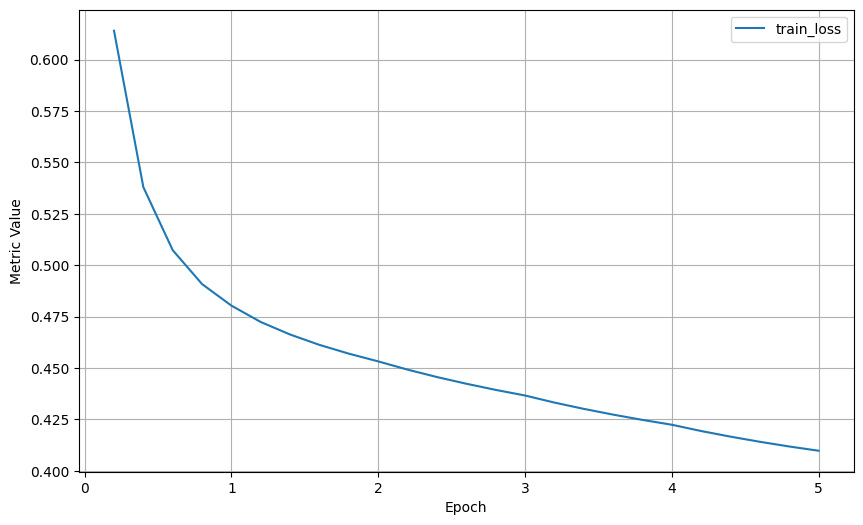

loss 0.410, 166268.4 tokens/sec on cuda


In [34]:
lr, num_epochs = 0.002, 5
train(net, data_iter, lr, num_epochs)

# Subword embedding

# Byte Pair Encoding

Initialzing the vocabulary of symbols with the lowercase English alphabet, the '_' and '[unk]' symbols

In [35]:
import collections

symbols = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '_', '[unk]']

Creating an example raw_token_freqs

In [36]:
raw_token_freqs = {'fast_': 4, 'faster_': 3, 'tall_': 5, 'taller_': 4}
token_freqs = {}
for token, freqs in raw_token_freqs.items():
    token_freqs[' '.join(list(token))] = raw_token_freqs[token]
print(token_freqs)

{'f a s t _': 4, 'f a s t e r _': 3, 't a l l _': 5, 't a l l e r _': 4}


In [37]:
def get_max_freq_pair(token_freqs):
    """Return the symbol pair with the highest frequency."""
    pairs = collections.defaultdict(int)
    for token, freq in token_freqs.items():
        symbols = token.split(' ')
        for i in range(len(symbols) - 1):
            pairs[symbols[i], symbols[i + 1]] += freq
    return max(pairs, key=pairs.get)

In [38]:
def merge_symbols(max_freq_pair, token_freqs):
    symbols.append(''.join(max_freq_pair))
    new_token_freqs = {}
    for token, freq in token_freqs.items():
        new_token = token.replace(' '.join(max_freq_pair), ''.join(max_freq_pair))
        new_token_freqs[new_token] = token_freqs[token]
    return new_token_freqs

In [39]:
num_merges = 10
for _ in range(num_merges):
    max_freq_pair = get_max_freq_pair(token_freqs)
    token_freqs = merge_symbols(max_freq_pair, token_freqs)
    print('max_freq_pair:', max_freq_pair)
    print('token_freqs:', token_freqs)
    print('symbols:', symbols)

max_freq_pair: ('t', 'a')
token_freqs: {'f a s t _': 4, 'f a s t e r _': 3, 'ta l l _': 5, 'ta l l e r _': 4}
symbols: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '_', '[unk]', 'ta']
max_freq_pair: ('ta', 'l')
token_freqs: {'f a s t _': 4, 'f a s t e r _': 3, 'tal l _': 5, 'tal l e r _': 4}
symbols: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '_', '[unk]', 'ta', 'tal']
max_freq_pair: ('tal', 'l')
token_freqs: {'f a s t _': 4, 'f a s t e r _': 3, 'tall _': 5, 'tall e r _': 4}
symbols: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '_', '[unk]', 'ta', 'tal', 'tall']
max_freq_pair: ('f', 'a')
token_freqs: {'fa s t _': 4, 'fa s t e r _': 3, 'tall _': 5, 'tall e r _': 4}
symbols: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l

In [40]:
def segment_BPE(tokens, symbols):
    outputs = []
    for token in tokens:
        start, end = 0, len(token)
        cur_output = []
        # Segment token with the longest possible subwords from symbols
        while start < len(token) and start < end:
            if token[start: end] in symbols:
                cur_output.append(token[start: end])
                start = end
                end = len(token)
            else:
                end -= 1
        if start < len(token):
            cur_output.append('[UNK]')
        outputs.append(' '.join(cur_output))
    return outputs

In [41]:
tokens = ['tallest_', 'fatter_']
print(segment_BPE(tokens, symbols))

['tall e s t _', 'fa t t er_']


# Word Similarity and Analogy

## Loading Pretrained Word Vectors

In [42]:
class TokenEmbeddings:
    def __init__(self, embedding_name):
        self.idx_to_token, self.idx_to_vec = self._load_embedding(embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in
                             enumerate(self.idx_to_token)}

    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ['<unk>'], []
        with open(embedding_name, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.split(' ')
                if len(parts) > 2:
                    token = parts[0]
                    idx_to_token.append(token)
                    idx_to_vec.append([float(x) for x in parts[1:]])
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, torch.tensor(idx_to_vec)

    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx)
                   for token in tokens]
        return self.idx_to_vec[torch.tensor(indices)]

    def __len__(self):
        return len(self.idx_to_token)

In [43]:
glove_6b50d = TokenEmbeddings('glove.6B.50d/vec.txt')

In [44]:
len(glove_6b50d)

400001

In [45]:
glove_6b50d.token_to_idx['beautiful'], glove_6b50d.idx_to_token[3367]

(3367, 'beautiful')

## Applying Pretrained Word Vectors

### Word Similarity

In [46]:
def knn(W, x, k):
    # Add 1e-9 for numerical stability
    cos = torch.mv(W, x.reshape(-1,)) / (
        torch.sqrt(torch.sum(W * W, axis=1) + 1e-9) *
        torch.sqrt((x * x).sum()))
    _, topk = torch.topk(cos, k=k)
    return topk, [cos[int(i)] for i in topk]

In [47]:
def get_similar_tokens(query_token, k, embed):
    topk, cos = knn(embed.idx_to_vec, embed[[query_token]], k + 1)
    for i, c in zip(topk[1:], cos[1:]):  # Exclude the input word
        print(f'cosine sim={float(c):.3f}: {embed.idx_to_token[int(i)]}')

In [48]:
get_similar_tokens('chip', 3, glove_6b50d)

cosine sim=0.856: chips
cosine sim=0.749: intel
cosine sim=0.749: electronics


In [49]:
get_similar_tokens('baby', 3, glove_6b50d)

cosine sim=0.839: babies
cosine sim=0.800: boy
cosine sim=0.792: girl


In [50]:
get_similar_tokens('beautiful', 3, glove_6b50d)

cosine sim=0.921: lovely
cosine sim=0.893: gorgeous
cosine sim=0.830: wonderful


### Word Analogy

In [51]:
def get_analogy(token_a, token_b, token_c, embed):
    vecs = embed[[token_a, token_b, token_c]]
    x = vecs[1] - vecs[0] + vecs[2]
    topk, cos = knn(embed.idx_to_vec, x, 1)
    return embed.idx_to_token[int(topk[0])]  # Remove unknown words

In [52]:
print(get_analogy('man', 'woman', 'son', glove_6b50d))

daughter


In [53]:
get_analogy('beijing', 'china', 'tokyo', glove_6b50d)

'japan'

In [54]:
get_analogy('bad', 'worst', 'big', glove_6b50d)

'biggest'

In [55]:
get_analogy('do', 'did', 'go', glove_6b50d)

'went'

# Bidirectional Encoder Representations from Transformers (BERT)

## Input Representation

In [56]:
def get_tokens_and_segments(tokens_a, tokens_b = None):
    tokens = ['<cls>'] + tokens_a + ['<sep>']
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None:
        tokens += tokens_b + ['<sep>']
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments

In [57]:
class BERTEncoder(nn.Module):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout, max_len = 1000, **kwargs):
        super(BERTEncoder, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f"{i}", nn.TransformerEncoderLayer(d_model=num_hiddens, nhead=num_heads, dim_feedforward=ffn_num_hiddens, dropout=dropout, activation='gelu'))
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, num_hiddens))

    def forward(self, tokens, segments, valid_lens):
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding.data[:, :X.shape[1], :]
        
        # For now, don't use padding masks since sequences are already padded to same length
        # This avoids the batch size mismatch issues
        padding_mask = None
        
        for blk in self.blks:
            X = blk(X, src_key_padding_mask=padding_mask)
        return X

In [58]:
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
ffn_num_input, num_blks, dropout = 768, 2, 0.2
encoder = BERTEncoder(vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                      num_blks, dropout)

In [59]:
tokens = torch.randint(0, vocab_size, (2, 8))
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])
encoded_X = encoder(tokens, segments, None)
encoded_X.shape

torch.Size([2, 8, 768])

## Pretraining Tasks

### Masked Language Modeling

In [60]:
class MaskLM(nn.Module):
    """The masked language model task of BERT."""
    def __init__(self, vocab_size, num_hiddens, **kwargs):
        super(MaskLM, self).__init__(**kwargs)
        self.mlp = nn.Sequential(nn.LazyLinear(num_hiddens),
                                 nn.ReLU(),
                                 nn.LayerNorm(num_hiddens),
                                 nn.LazyLinear(vocab_size))

    def forward(self, X, pred_positions):
        num_pred_positions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        # Suppose that `batch_size` = 2, `num_pred_positions` = 3, then
        # `batch_idx` is `torch.tensor([0, 0, 0, 1, 1, 1])`
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
        masked_X = X[batch_idx, pred_positions]
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        mlm_Y_hat = self.mlp(masked_X)
        return mlm_Y_hat

In [61]:
mlm = MaskLM(vocab_size, num_hiddens)
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])
mlm_Y_hat = mlm(encoded_X, mlm_positions)
mlm_Y_hat.shape

torch.Size([2, 3, 10000])

In [62]:
mlm_Y = torch.tensor([[7, 8, 9], [10, 20, 30]])
loss = nn.CrossEntropyLoss(reduction='none')
mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y.reshape(-1))
mlm_l.shape

torch.Size([6])

### Next Sentence Prediction

In [63]:
class NextSentencePred(nn.Module):
    def __init__(self, **kwargs):
        super(NextSentencePred, self).__init__(**kwargs)
        self.output = nn.LazyLinear(2)
    
    def forward(self, X):
        return self.output(X)

In [64]:
encoded_X = torch.flatten(encoded_X, start_dim=1)
nsp = NextSentencePred()
nsp_Y_hat = nsp(encoded_X)
nsp_Y_hat.shape

torch.Size([2, 2])

In [65]:
nsp_y = torch.tensor([0, 1])
nsp_l = loss(nsp_Y_hat, nsp_y)
nsp_l.shape

torch.Size([2])

## Putting it all together

In [66]:
class BERTModel(nn.Module):
    """The BERT model."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, max_len=1000):
        super(BERTModel, self).__init__()
        self.encoder = BERTEncoder(vocab_size, num_hiddens, ffn_num_hiddens,
                                   num_heads, num_blks, dropout,
                                   max_len=max_len)
        self.hidden = nn.Sequential(nn.LazyLinear(num_hiddens),
                                    nn.Tanh())
        self.mlm = MaskLM(vocab_size, num_hiddens)
        self.nsp = NextSentencePred()

    def forward(self, tokens, segments, valid_lens=None, pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        # The hidden layer of the MLP classifier for next sentence prediction.
        # 0 is the index of the '<cls>' token
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))
        return encoded_X, mlm_Y_hat, nsp_Y_hat

In [67]:
def download_wikitext():
    import requests
    import os
    from time import sleep

    # Create directory if it doesn't exist
    os.makedirs('wikitext', exist_ok=True)
    
    # Define splits and their endpoints
    splits = ['train', 'validation', 'test']
    base_url = "https://datasets-server.huggingface.co/rows"
    dataset = "wikitext-2-raw-v1"
    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    for split in splits:
        print(f"Downloading {split} split...")
        all_rows = []
        offset = 0
        try:
            # Construct URL for current batch
            url = f"{base_url}?dataset=Salesforce%2Fwikitext&config={dataset}&split={split}&offset={offset}&length=100"
            print(url)
            response = requests.get(url, headers=headers)
            response.raise_for_status()  # Raise an exception for bad status codes
                
            try:
                data = response.json()
            except ValueError as e:
                print(f"Failed to parse JSON from response: {e}")
                print("Response content:", response.text[:200])  # Print first 200 chars of response
                break
                
            # Extract text from rows
            rows = data.get('rows', [])
            if not rows:  # No more data
                break
                    
            for row in rows:
                if isinstance(row, dict) and 'row' in row and 'text' in row['row']:
                    text = row['row']['text']
                    if text.strip():  # Only add non-empty lines
                           all_rows.append(text)
                
            offset += len(rows)
            if offset >= data.get('num_rows_total', offset):
                break
                    
            sleep(0.1)  # Add a small delay between requests
                
        except requests.exceptions.RequestException as e:
            print(f"Error during request: {e}")
            break
        
    # Save to file
    output_file = f"wikitext/wiki.{split}.tokens"
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write('\n'.join(all_rows))
        
    print(f"Saved {len(all_rows)} rows to {output_file}")

# Execute the function
#download_wikitext()



In [68]:
def tokenize(lines, token='word'):
    """Split text lines into word or character tokens.

    Defined in :numref:`sec_text_preprocessing`"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)

In [69]:
def _read_wiki(data_dir):
    file_name = os.path.join(data_dir, 'wiki.train.tokens')
    print(file_name)
    with open(file_name, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    # Uppercase letters are converted to lowercase ones
    paragraphs = [line.strip().lower().split(' . ')
                  for line in lines if len(line.split(' . ')) >= 2]
    random.shuffle(paragraphs)
    return paragraphs

In [70]:
def _get_next_sentence(sentence, next_sentence, paragraphs):
    if random.random() < 0.5:
        is_next = True
    else:
        # `paragraphs` is a list of lists of lists
        next_sentence = random.choice(random.choice(paragraphs))
        is_next = False
    return sentence, next_sentence, is_next

In [71]:
def _get_nsp_data_from_paragraph(paragraph, paragraphs, vocab, max_len):
    nsp_data_from_paragraph = []
    for i in range(len(paragraph) - 1):
        tokens_a, tokens_b, is_next = _get_next_sentence(
            paragraph[i], paragraph[i + 1], paragraphs)
        # Consider 1 '<cls>' token and 2 '<sep>' tokens
        if len(tokens_a) + len(tokens_b) + 3 > max_len:
            continue
        tokens, segments = get_tokens_and_segments(tokens_a, tokens_b)
        nsp_data_from_paragraph.append((tokens, segments, is_next))
    return nsp_data_from_paragraph


In [72]:
def _replace_mlm_tokens(tokens, candidate_pred_positions, num_mlm_preds,
                        vocab):
    # For the input of a masked language model, make a new copy of tokens and
    # replace some of them by '<mask>' or random tokens
    mlm_input_tokens = [token for token in tokens]
    pred_positions_and_labels = []
    # Shuffle for getting 15% random tokens for prediction in the masked
    # language modeling task
    random.shuffle(candidate_pred_positions)
    for mlm_pred_position in candidate_pred_positions:
        if len(pred_positions_and_labels) >= num_mlm_preds:
            break
        masked_token = None
        # 80% of the time: replace the word with the '<mask>' token
        if random.random() < 0.8:
            masked_token = '<mask>'
        else:
            # 10% of the time: keep the word unchanged
            if random.random() < 0.5:
                masked_token = tokens[mlm_pred_position]
            # 10% of the time: replace the word with a random word
            else:
                masked_token = random.choice(vocab.idx_to_token)
        mlm_input_tokens[mlm_pred_position] = masked_token
        pred_positions_and_labels.append(
            (mlm_pred_position, tokens[mlm_pred_position]))
    return mlm_input_tokens, pred_positions_and_labels

In [73]:
def _get_mlm_data_from_tokens(tokens, vocab):
    candidate_pred_positions = []
    # `tokens` is a list of strings
    for i, token in enumerate(tokens):
        # Special tokens are not predicted in the masked language modeling
        # task
        if token in ['<cls>', '<sep>']:
            continue
        candidate_pred_positions.append(i)
    # 15% of random tokens are predicted in the masked language modeling task
    num_mlm_preds = max(1, round(len(tokens) * 0.15))
    mlm_input_tokens, pred_positions_and_labels = _replace_mlm_tokens(
        tokens, candidate_pred_positions, num_mlm_preds, vocab)
    pred_positions_and_labels = sorted(pred_positions_and_labels,
                                       key=lambda x: x[0])
    pred_positions = [v[0] for v in pred_positions_and_labels]
    mlm_pred_labels = [v[1] for v in pred_positions_and_labels]
    return vocab[mlm_input_tokens], pred_positions, vocab[mlm_pred_labels]

In [74]:
def _pad_bert_inputs(examples, max_len, vocab):
    max_num_mlm_preds = round(max_len * 0.15)
    all_token_ids, all_segments, valid_lens,  = [], [], []
    all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
    nsp_labels = []
    for (token_ids, pred_positions, mlm_pred_label_ids, segments,
         is_next) in examples:
        all_token_ids.append(torch.tensor(token_ids + [vocab['<pad>']] * (
            max_len - len(token_ids)), dtype=torch.long))
        all_segments.append(torch.tensor(segments + [0] * (
            max_len - len(segments)), dtype=torch.long))
        # `valid_lens` excludes count of '<pad>' tokens
        valid_lens.append(torch.tensor(len(token_ids), dtype=torch.float32))
        all_pred_positions.append(torch.tensor(pred_positions + [0] * (
            max_num_mlm_preds - len(pred_positions)), dtype=torch.long))
        # Predictions of padded tokens will be filtered out in the loss via
        # multiplication of 0 weights
        all_mlm_weights.append(
            torch.tensor([1.0] * len(mlm_pred_label_ids) + [0.0] * (
                max_num_mlm_preds - len(pred_positions)),
                dtype=torch.float32))
        all_mlm_labels.append(torch.tensor(mlm_pred_label_ids + [0] * (
            max_num_mlm_preds - len(mlm_pred_label_ids)), dtype=torch.long))
        nsp_labels.append(torch.tensor(is_next, dtype=torch.long))
    return (all_token_ids, all_segments, valid_lens, all_pred_positions,
            all_mlm_weights, all_mlm_labels, nsp_labels)

In [75]:
class _WikiTextDataset(torch.utils.data.Dataset):
    def __init__(self, paragraphs, max_len):
        # Input `paragraphs[i]` is a list of sentence strings representing a
        # paragraph; while output `paragraphs[i]` is a list of sentences
        # representing a paragraph, where each sentence is a list of tokens
        paragraphs = [tokenize(
            paragraph, token='word') for paragraph in paragraphs]
        sentences = [sentence for paragraph in paragraphs
                     for sentence in paragraph]
        self.vocab = Vocab(sentences, min_freq=5, reserved_tokens=[
            '<pad>', '<mask>', '<cls>', '<sep>'])
        # Get data for the next sentence prediction task
        examples = []
        for paragraph in paragraphs:
            examples.extend(_get_nsp_data_from_paragraph(
                paragraph, paragraphs, self.vocab, max_len))
        # Get data for the masked language model task
        examples = [(_get_mlm_data_from_tokens(tokens, self.vocab)
                      + (segments, is_next))
                     for tokens, segments, is_next in examples]
        # Pad inputs
        (self.all_token_ids, self.all_segments, self.valid_lens,
         self.all_pred_positions, self.all_mlm_weights,
         self.all_mlm_labels, self.nsp_labels) = _pad_bert_inputs(
            examples, max_len, self.vocab)

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx], self.all_pred_positions[idx],
                self.all_mlm_weights[idx], self.all_mlm_labels[idx],
                self.nsp_labels[idx])

    def __len__(self):
        return len(self.all_token_ids)

In [76]:
def load_data_wiki(batch_size, max_len):
    """Load the WikiText-2 dataset."""
    data_dir = "wikitext"
    paragraphs = _read_wiki(data_dir)
    train_set = _WikiTextDataset(paragraphs, max_len)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                        shuffle=True)
    return train_iter, train_set.vocab

In [77]:
batch_size, max_len = 64, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)

for (tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X,
     mlm_Y, nsp_y) in train_iter:
    print(tokens_X.shape, segments_X.shape, valid_lens_x.shape,
          pred_positions_X.shape, mlm_weights_X.shape, mlm_Y.shape,
          nsp_y.shape)
    break

wikitext\wiki.train.tokens
torch.Size([64, 64]) torch.Size([64, 64]) torch.Size([64]) torch.Size([64, 10]) torch.Size([64, 10]) torch.Size([64, 10]) torch.Size([64])


In [78]:
len(vocab)

190

# Pretraining BERT

In [79]:
def try_all_gpus():
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

In [80]:
batch_size, max_len = 64, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)
net = BERTModel(len(vocab), num_hiddens=128, ffn_num_hiddens=256, num_heads=2,
                    num_blks=2, dropout=0.2)
devices = try_all_gpus()
loss = nn.CrossEntropyLoss(reduction='none')

wikitext\wiki.train.tokens


In [81]:
devices

[device(type='cuda', index=0)]

In [82]:
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    # Forward pass
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape(-1).to(tokens_X.device),
                                  pred_positions_X)
    # Compute masked language model loss
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) *\
    mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # Compute next sentence prediction loss
    nsp_l = loss(nsp_Y_hat, nsp_y).sum()  # Sum to get scalar
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

In [83]:
devices

[device(type='cuda', index=0)]

In [84]:
def train_bert(train_iter, net, loss, vocab_size, num_steps, devices=None):
    # Handle devices parameter - convert to list if it's a single device
    if isinstance(devices, int):
        devices = [devices]
    elif devices is None:
        devices = [torch.device('cuda' if torch.cuda.is_available() else 'cpu')]
    
    # Validate and filter available devices
    available_devices = []
    for device in devices:
        if isinstance(device, int):
            device_obj = torch.device(f'cuda:{device}')
        else:
            device_obj = device
            
        # Check if device is available
        if device_obj.type == 'cuda':
            if device_obj.index is not None and device_obj.index < torch.cuda.device_count():
                available_devices.append(device_obj)
            elif device_obj.index is None and torch.cuda.is_available():
                available_devices.append(torch.device('cuda:0'))
        else:  # CPU device
            available_devices.append(device_obj)
    
    # Fallback to CPU if no valid devices found
    if not available_devices:
        available_devices = [torch.device('cpu')]
    
    # Use the first available device
    device = available_devices[0]
    
    # Move model to device FIRST
    net = net.to(device)
    
    # Get a sample batch and move to device before initializing the model
    sample_batch = next(iter(train_iter))
    tokens_X, segments_X, valid_lens_x, pred_positions_X = sample_batch[:4]
    
    # Move sample tensors to device
    tokens_X = tokens_X.to(device)
    segments_X = segments_X.to(device)
    valid_lens_x = valid_lens_x.to(device)
    pred_positions_X = pred_positions_X.to(device)
    
    # Initialize the model with device-moved tensors
    net(tokens_X, segments_X, valid_lens_x, pred_positions_X)
    
    trainer = torch.optim.Adam(net.parameters(), lr=0.01)
    step, timer = 0, Timer()
    animator = Animator(xlabel='step', ylabel='loss', legend=['mlm', 'nsp'])
    # Sum of masked language modeling losses, sum of next sentence prediction
    # losses, no. of sentence pairs, count
    metric = Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X,\
            mlm_weights_X, mlm_Y, nsp_y in train_iter:
            tokens_X = tokens_X.to(device)
            segments_X = segments_X.to(device)
            valid_lens_x = valid_lens_x.to(device)
            pred_positions_X = pred_positions_X.to(device)
            mlm_weights_X = mlm_weights_X.to(device)
            mlm_Y, nsp_y = mlm_Y.to(device), nsp_y.to(device)
            trainer.zero_grad()
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3], None))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(device)}')
    animator.show()

MLM loss 1525.378, NSP loss 46.434
3701.6 sentence pairs/sec on cuda:0


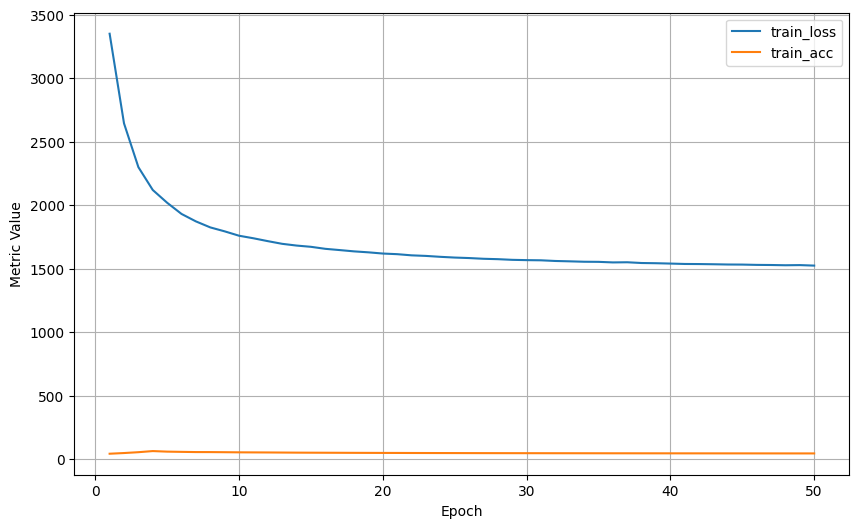

In [85]:
train_bert(train_iter, net, loss, len(vocab), 50, devices)


## Representing text with BERT

In [86]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

In [87]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
# Tokens: '<cls>', 'a', 'crane', 'is', 'flying', '<sep>'
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

(torch.Size([1, 6, 128]),
 torch.Size([1, 128]),
 tensor([-1.0832,  1.3653,  0.3304], device='cuda:0', grad_fn=<SliceBackward0>))

In [88]:
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# Tokens: '<cls>', 'a', 'crane', 'driver', 'came', '<sep>', 'he', 'just',
# 'left', '<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

(torch.Size([1, 10, 128]),
 torch.Size([1, 128]),
 tensor([-1.2077,  1.3457,  0.2569], device='cuda:0', grad_fn=<SliceBackward0>))